# NYC Motor Vehicle Collisions & Crashes

## Team Members
### Alfonso Toruno, 
### Chris Campell, 
### Kamal Mukherjee, 
### Roslyn

# Scope of the Project
## Our goal is to determine the effect of various traffic related changes in NYC Motor Vehicle Collisions during the past decade
### Some of the noteworthy changes in NYC since 2011 are:-
#### Launch of Uber, Lyft and other ride share program in May 2011
#### Citibikes was launched in May 2013
#### NYC speed limits were reduced from 30 mph to 25 mph in November 2014


## Being New Yorkers, we wanted to find out:-
### 1. How all these changes impacted the NYC traffic situation in terms of Motor Vehicle Collisions & Crashes. 
### 2. Since, each borough of the city has their own unique personality, we wanted to explore if there are any significant difference in number of accidents across the boroughs.
### 3. What are the root causes of accident? is it just alcohol or there are other issues?
### 4. Are most of accidents caused by Taxicab, Bus or another vehicle type?
### 5. Does seasonality have any significant role in NYC Motor Vehicle Collisions & Crashes?

# Identifying reliable, trusting source of Data
#### Our first challenge was to gather data from a source that we can trust!
#### After a brief searching on the web, we were able to quickly identify a reliable source of data i.e. NYC DMV. 
#### The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. 
#### The police report (MV104-AN) is required to be filled out for collisions where someone is injured or killed, or where there is at least 1000 dollar worth of damage.

# Data Exploration
#### NYC DMV offers the collisions and crash table data as CSV download as well as API endpoint. However, while reviewing the data from both sources, we realized that the csv version of the table contains more complete set of information. Also, though the NYC DMV is offering data table between 2011 and 2020, we found 2012 through 2018 contains most reliable set of data.

#  Clean up Process
#### To effectively clean the data, we focused on following metrics: -
#### Eliminate duplicate, irrelevant observations
#### Handle any typographical issue with categorical data i.e. convert them all to a uniform case (upper)
#### Fix any structural errors
#### Handle missing categorical and numeric data

# Limitations of the dataset 
### DMV's dataset doesn't provide any construction information at the area of accident site
### We were unable to find a reliable historical NYC weather report to observe how rain, snow and other weather issues could impact motor vehicles collisions and crash
### We have noticed an upward trend in accident count. However, there is no data available on how many vehicles are on the street and we were unable to determine number of vehicles on the streets of NYC vs. accident count.

In [49]:
# importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import csv
from datetime import datetime
import gmaps

# Import API key
from api_keys import g_key

# importing 2012 - 2018 data from csv downloaded from NYC DMV website
csv_file = "Resources/Motor_Vehicle_Collisions.csv"
dmv_all_data = pd.read_csv(csv_file, encoding="ISO-8859-1", low_memory=False)

# revising the dataframe with columns that has relevance for our analysis
dmv_all_data = dmv_all_data[['CRASH DATE', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
                            'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
                            'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
                            'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
                            'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
                            'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 
                            'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']]

# displaying the dataframe and initial row count
count_row = "{:,.0f}".format(dmv_all_data.shape[0])
print(f'Total row of the dataframe before any clean up: {count_row}')
dmv_all_data.head()

Total row of the dataframe before any clean up: 1,684,041


,CRASH DATE,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,07/04/2018,BROOKLYN,11225,40.663456,-73.95836,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle
1,07/18/2018,NaN,NaN,40.849236,-73.92371,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,07/12/2018,NaN,NaN,40.696014,-73.92153,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle
3,07/18/2018,BRONX,10473,40.816906,-73.84755,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,Taxi,Station Wagon/Sport Utility Vehicle
4,07/03/2018,MANHATTAN,10065,40.761856,-73.96343,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,Taxi,NaN


In [50]:
# Adding year & month column to the dataframe to create timeline
dmv_cleaned_data = dmv_all_data.assign(YEAR=dmv_all_data['CRASH DATE'].str.slice(6, 10), 
                                        MONTH=dmv_all_data['CRASH DATE'].str.slice(0, 2).astype(int))
# Convert month by name
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
group_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
dmv_cleaned_data["MONTH NAME"] = pd.cut(dmv_cleaned_data["MONTH"], bins, labels=group_names, include_lowest=True)

# Dropping rows where an important column contains NaN Value
dmv_cleaned_data.dropna(subset=['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1',
                            'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED'], inplace=True)

# Further cleaning up the dataset by dropping rows with meaningless values
dmv_cleaned_data = dmv_cleaned_data.loc[(dmv_cleaned_data['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified') & 
                                      (dmv_cleaned_data['VEHICLE TYPE CODE 1'] != 'UNKNOWN')]
# Applying uppercase to the text columns for proper groupping etc.
dmv_cleaned_data['BOROUGH'] = dmv_cleaned_data['BOROUGH'].str.upper()
dmv_cleaned_data['CONTRIBUTING FACTOR VEHICLE 1'] = dmv_cleaned_data['CONTRIBUTING FACTOR VEHICLE 1'].str.upper()
dmv_cleaned_data['VEHICLE TYPE CODE 1'] = dmv_cleaned_data['VEHICLE TYPE CODE 1'].str.upper()

# creating dataset for 2012 and exporting to csv for local use
dmv_2012_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2012')]
dmv_2012_data.to_csv("Resources/dmv_2012_data.csv", encoding="utf-8", index=False)

# creating dataset for 2013 and exporting to csv for local use
dmv_2013_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2013')]
dmv_2013_data.to_csv("Resources/dmv_2013_data.csv", encoding="utf-8", index=False)

# creating dataset for 2014 and exporting to csv for local use
dmv_2014_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2014')]
dmv_2014_data.to_csv("Resources/dmv_2014_data.csv", encoding="utf-8", index=False)

# creating dataset for 2015 and exporting to csv for local use
dmv_2015_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2015')]
dmv_2015_data.to_csv("Resources/dmv_2015_data.csv", encoding="utf-8", index=False)

# creating dataset for 2016 and exporting to csv for local use
dmv_2016_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2016')]
dmv_2016_data.to_csv("Resources/dmv_2016_data.csv", encoding="utf-8", index=False)

# creating dataset for 2017 and exporting to csv for local use
dmv_2017_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2017')]
dmv_2017_data.to_csv("Resources/dmv_2017_data.csv", encoding="utf-8", index=False)

# creating dataset for 2018 and exporting to csv for local use
dmv_2018_data = dmv_cleaned_data.loc[(dmv_cleaned_data['YEAR'] == '2018')]
dmv_2018_data.to_csv("Resources/dmv_2018_data.csv", encoding="utf-8", index=False)

# displaying the cleaned dataframe and final row count
count_row = "{:,.0f}".format(dmv_cleaned_data.shape[0])
print(f'Total number of rows of the CLEANED dataframe: {count_row}')
dmv_cleaned_data.head()

Total number of rows of the CLEANED dataframe: 669,940


,CRASH DATE,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,YEAR,MONTH,MONTH NAME
0,07/04/2018,BROOKLYN,11225,40.663456,-73.95836,0.0,0.0,0,0,0,0,0,0,PASSING TOO CLOSELY,Unspecified,SEDAN,Station Wagon/Sport Utility Vehicle,2018,7,Jul
3,07/18/2018,BRONX,10473,40.816906,-73.84755,0.0,0.0,0,0,0,0,0,0,PASSING TOO CLOSELY,Unspecified,TAXI,Station Wagon/Sport Utility Vehicle,2018,7,Jul
4,07/03/2018,MANHATTAN,10065,40.761856,-73.96343,0.0,0.0,0,0,0,0,0,0,FAILURE TO YIELD RIGHT-OF-WAY,NaN,TAXI,NaN,2018,7,Jul
10,07/15/2018,QUEENS,11358,40.760784,-73.80677,0.0,0.0,0,0,0,0,0,0,FAILURE TO YIELD RIGHT-OF-WAY,Unspecified,SEDAN,Station Wagon/Sport Utility Vehicle,2018,7,Jul
11,07/22/2018,BRONX,10453,40.861862,-73.91282,0.0,0.0,0,0,0,0,0,0,FOLLOWING TOO CLOSELY,Unspecified,STATION WAGON/SPORT UTILITY VEHICLE,Sedan,2018,7,Jul


In [51]:
# 2018 Motor Vehicle Collisions Analysis
# Dataframe of accidents by borough
accidents_by_borough_2018 = dmv_2018_data.groupby(["BOROUGH"])
total_by_borough = accidents_by_borough_2018["BOROUGH"].count().map("{:,.0f}".format)

# creating new dataframe for charts
monthly_total_accident = pd.DataFrame({
    "Total Accident": total_by_borough
})

# display dataframe as point of reference
monthly_total_accident

,Total Accident
BOROUGH,
BRONX,"15,979"
BROOKLYN,"32,044"
MANHATTAN,"23,535"
QUEENS,"31,715"
STATEN ISLAND,"5,078"


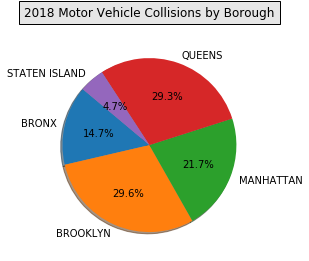

In [52]:
# 2018 Motor Vehicle Collisions Analysis
# Number of accidents by borough
accidents_by_borough_2018 = dmv_2018_data.groupby('BOROUGH').size()

# Labels for the sections of our pie chart
labels = ["BRONX", "BROOKLYN", "MANHATTAN", "QUEENS", "STATEN ISLAND"]

# The colors of each section of the pie chart
colors = ["C0", "C1", "C2", "C3", "C4"]

# plotting pie chart and removing y-axis label
_=accidents_by_borough_2018.plot.pie(labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140 )
_=plt.title("2018 Motor Vehicle Collisions by Borough", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.ylabel("")
plt.savefig("Images/accident_by_bourough_2018.png")

In [53]:
# Generate a dataframe to analyze the level of severity of the accidents
accidents_with_no_injury = len(dmv_2018_data.loc[(dmv_2018_data['NUMBER OF PERSONS INJURED'].astype(int)==0) & 
                                             (dmv_2018_data['NUMBER OF PERSONS KILLED'].astype(int)==0)])
accidents_with_injury = len(dmv_2018_data.loc[(dmv_2018_data['NUMBER OF PERSONS INJURED'].astype(int)>0)])
accidents_with_fatality = len(dmv_2018_data.loc[(dmv_2018_data['NUMBER OF PERSONS KILLED'].astype(int)>0)])
total_accidents_2018 = accidents_with_no_injury + accidents_with_injury + accidents_with_fatality
accident_2018_dict = [{
    "No Injury": "{:,.0f}".format(accidents_with_no_injury),
    "Injury": "{:,.0f}".format(accidents_with_injury),
    "Fatality": "{:,.0f}".format(accidents_with_fatality),
    "Total Accidents": "{:,.0f}".format(total_accidents_2018)
}]
accident_2018_df = pd.DataFrame(accident_2018_dict)
accident_2018_df

,No Injury,Injury,Fatality,Total Accidents
0,"87,302","20,980",97,"108,379"


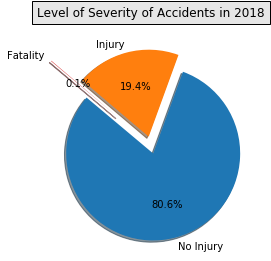

In [54]:
# Generate a pie chart to analyze the level of severity of the accidents
# The value of different level of accident severity
total_accidents = [accidents_with_no_injury, accidents_with_injury, accidents_with_fatality]

# Labels for the sections of our pie chart
labels = ["No Injury", "Injury", "Fatality"]

# The colors of each section of the pie chart
colors = ["C0", "C1", "C3"]

# trying to seperate the "Fatality" section from the others
explode = (0.1, 0.1, 0.5)

# plotting pie chart and removing y-axis label
_=plt.pie(total_accidents, labels=labels, explode=explode, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
_=plt.title("Level of Severity of Accidents in 2018", bbox={'facecolor':'.9', 'pad':5}, pad=20)
_=plt.ylabel("")
plt.savefig("Images/accident_by_severity_2018.png")

In [55]:
# 2018 Motor Vehicle Collisions Analysis
# creating new dataframe grouped by Month
monthly_data_2018 = dmv_2018_data.groupby(["MONTH NAME"])
accident_by_time_point_2018 = monthly_data_2018["MONTH NAME"].count()

# creating new dataframe for charts
monthly_total_accident = pd.DataFrame({
    "Total Accident": accident_by_time_point_2018.map("{:,.0f}".format)
})

# display dataframe as point of reference
monthly_total_accident

,Total Accident
MONTH NAME,
Jan,"8,633"
Feb,"7,631"
Mar,"9,157"
Apr,"8,506"
May,"9,756"
Jun,"9,702"
Jul,"9,257"
Aug,"9,123"
Sep,"8,929"


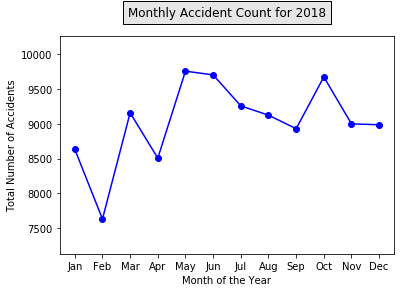

In [56]:
# Generate a line chart showing total number of accidents per month for 2018
group_keys = list(monthly_data_2018.groups.keys())
plt.plot(group_keys, accident_by_time_point_2018, marker ='o', color='blue', label="Sine")
ymin = min(accident_by_time_point_2018)-500
ymax = max(accident_by_time_point_2018)+500

# Adding axis labels
_=plt.title("Monthly Accident Count for 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Month of the Year")
_=plt.ylabel("Total Number of Accidents")
_=plt.ylim(ymin, ymax)
plt.savefig("Images/accident_by_month_2018.png")

In [57]:
# Group 2018 dataframe by vehicle type and sort by accident count to identify top ten accident prone vehicle for NYC
accident_by_vehicle_type_2018 = dmv_2018_data.groupby(["VEHICLE TYPE CODE 1"]).size()
accident_by_vehicle_type_2018_df = pd.DataFrame({
    "Total Accident": accident_by_vehicle_type_2018,
})

# Refining the dataframe for our analysis
accident_by_vehicle_type_2018_df["Vehicle Type"] = accident_by_vehicle_type_2018_df.index
accident_by_vehicle_type_2018_df.sort_values(by=["Total Accident"], ascending=False, inplace=True)
top_ten_vehicle_type_2018 = accident_by_vehicle_type_2018_df[:10]
top_ten_vehicle_type_2018

,Total Accident,Vehicle Type
VEHICLE TYPE CODE 1,,
SEDAN,32831,SEDAN
STATION WAGON/SPORT UTILITY VEHICLE,25783,STATION WAGON/SPORT UTILITY VEHICLE
PASSENGER VEHICLE,16514,PASSENGER VEHICLE
SPORT UTILITY / STATION WAGON,13033,SPORT UTILITY / STATION WAGON
TAXI,6060,TAXI
PICK-UP TRUCK,3440,PICK-UP TRUCK
BOX TRUCK,1795,BOX TRUCK
BUS,1197,BUS
BIKE,1052,BIKE


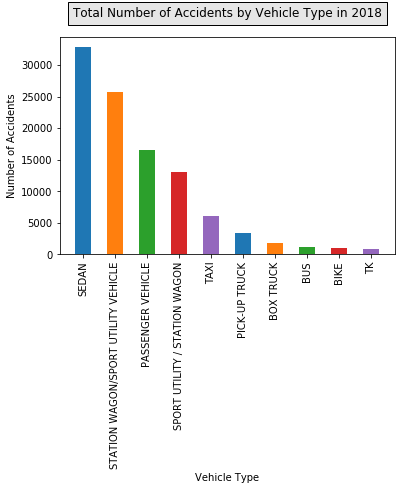

In [58]:
# Generate a bar chart to plot accident count by vehicle type
vehicle_type = top_ten_vehicle_type_2018["Vehicle Type"]
accident = top_ten_vehicle_type_2018["Total Accident"]
plt.bar(vehicle_type, accident, color=['C0', 'C1', 'C2', 'C3', 'C4'], width=0.5, align="center")
_=plt.title("Total Number of Accidents by Vehicle Type in 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Vehicle Type")
_=plt.ylabel("Number of Accidents")
_=plt.xticks(rotation=90)
plt.savefig("Images/vehicle_type_2018.png")

In [59]:
# Group 2018 dataframe by reason and sort by accident count to identify top ten reasons of accident for NYC
accident_by_reason_2018 = dmv_2018_data.groupby(["CONTRIBUTING FACTOR VEHICLE 1"]).size()
accident_by_reason_2018_df = pd.DataFrame({
    "Total Accident": accident_by_reason_2018,
})

# Refining the dataframe for our analysis
accident_by_reason_2018_df["Reason for Accident"] = accident_by_reason_2018_df.index
accident_by_reason_2018_df.sort_values(by=["Total Accident"], ascending=False, inplace=True)
top_ten_reason_2018 = accident_by_reason_2018_df[:10]
top_ten_reason_2018

,Total Accident,Reason for Accident
CONTRIBUTING FACTOR VEHICLE 1,,
DRIVER INATTENTION/DISTRACTION,34693,DRIVER INATTENTION/DISTRACTION
FAILURE TO YIELD RIGHT-OF-WAY,11058,FAILURE TO YIELD RIGHT-OF-WAY
FOLLOWING TOO CLOSELY,9331,FOLLOWING TOO CLOSELY
BACKING UNSAFELY,8637,BACKING UNSAFELY
PASSING TOO CLOSELY,7081,PASSING TOO CLOSELY
PASSING OR LANE USAGE IMPROPER,6537,PASSING OR LANE USAGE IMPROPER
OTHER VEHICULAR,4244,OTHER VEHICULAR
TURNING IMPROPERLY,3824,TURNING IMPROPERLY
UNSAFE LANE CHANGING,3787,UNSAFE LANE CHANGING


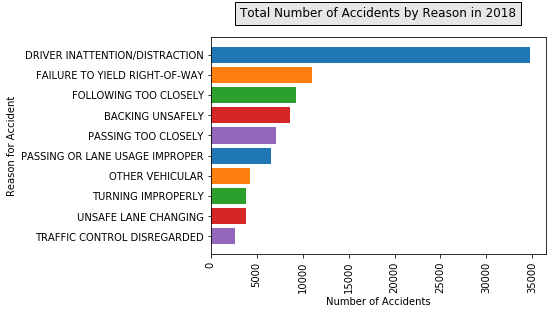

In [60]:
# Generate a horizontal bar chart to plot accident count by reason
reason = top_ten_reason_2018["Reason for Accident"]
accident = top_ten_reason_2018["Total Accident"]
plt.barh(reason, accident, color=['C0', 'C1', 'C2', 'C3', 'C4'], align="center")
_=plt.title("Total Number of Accidents by Reason in 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Number of Accidents")
_=plt.ylabel("Reason for Accident")
_=plt.gca().invert_yaxis()
_=plt.xticks(rotation=90)
plt.savefig("Images/reason_2018.png")

In [61]:
# In November 2014, NYC passed a law reducing speed limit from 30 mph to 25 mph. The purpose of following series
# of visualizations is to observe any positive impact of the new spped limit.
# Create a dataframe showing annual accidents between 2012 and 2018
total_2012_accidents = len(dmv_2012_data)
total_2013_accidents = len(dmv_2013_data)
total_2014_accidents = len(dmv_2014_data)
total_2015_accidents = len(dmv_2015_data)
total_2016_accidents = len(dmv_2016_data)
total_2017_accidents = len(dmv_2017_data)
total_2018_accidents = len(dmv_2018_data)
year = pd.Series(["2012", "2013", "2014", "2015", "2016", "2017", "2018"])
accidents = pd.Series([total_2012_accidents, total_2013_accidents, total_2014_accidents, total_2015_accidents,
                        total_2016_accidents, total_2017_accidents, total_2018_accidents])
accident_dict = {
    "Year": year,
    "Total Accidents": accidents
}
annual_total_accident = pd.DataFrame(accident_dict)
annual_total_accident

,Year,Total Accidents
0,2012,29446
1,2013,60545
2,2014,69456
3,2015,84320
4,2016,93541
5,2017,103744
6,2018,108351


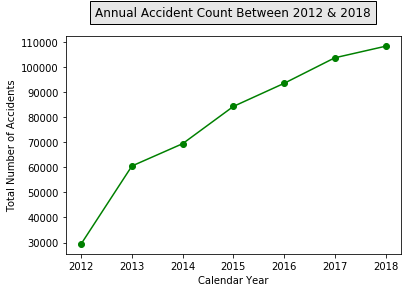

In [62]:
# create a line chart to visualize yearly total accidents between 2012 and 2018
year = annual_total_accident["Year"]
accidents = annual_total_accident["Total Accidents"]
plt.plot(year, accidents, marker ='o', color='green', label="Sine")

# Adding axis labels
_=plt.title("Annual Accident Count Between 2012 & 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Calendar Year")
_=plt.ylabel("Total Number of Accidents")
_=plt.savefig("Images/total_accidents_per_year.png")

In [63]:
# Create a dataframe showing annual accident injuries between 2012 and 2018
total_2012_injury = len(dmv_2012_data.loc[(dmv_2012_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2013_injury = len(dmv_2013_data.loc[(dmv_2013_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2014_injury = len(dmv_2014_data.loc[(dmv_2014_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2015_injury = len(dmv_2015_data.loc[(dmv_2015_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2016_injury = len(dmv_2016_data.loc[(dmv_2016_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2017_injury = len(dmv_2017_data.loc[(dmv_2017_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2018_injury = len(dmv_2018_data.loc[(dmv_2018_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
year = pd.Series(["2012", "2013", "2014", "2015", "2016", "2017", "2018"])
injury = pd.Series([total_2012_injury, total_2013_injury, total_2014_injury, total_2015_injury,
                        total_2016_injury, total_2017_injury, total_2018_injury])
injury_dict = {
    "Year": year,
    "Total Injury": injury
}
annual_total_injury = pd.DataFrame(injury_dict)
annual_total_injury

,Year,Total Injury
0,2012,6019
1,2013,12194
2,2014,12959
3,2015,15274
4,2016,17859
5,2017,19602
6,2018,20980


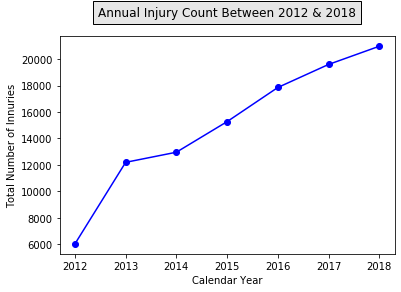

In [64]:
# create a line chart to visualize yearly total injury between 2012 and 2018
year = annual_total_injury["Year"]
injury = annual_total_injury["Total Injury"]
plt.plot(year, injury, marker ='o', color='blue', label="Sine")

# Adding axis labels
_=plt.title("Annual Injury Count Between 2012 & 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Calendar Year")
_=plt.ylabel("Total Number of Innuries")
_=plt.savefig("Images/total_injury_per_year.png")

In [65]:
# Create a dataframe showing annual accident deaths between 2012 and 2018
total_2012_death = len(dmv_2012_data.loc[(dmv_2012_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2013_death = len(dmv_2013_data.loc[(dmv_2013_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2014_death = len(dmv_2014_data.loc[(dmv_2014_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2015_death = len(dmv_2015_data.loc[(dmv_2015_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2016_death = len(dmv_2016_data.loc[(dmv_2016_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2017_death = len(dmv_2017_data.loc[(dmv_2017_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2018_death = len(dmv_2018_data.loc[(dmv_2018_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
year = pd.Series(["2012", "2013", "2014", "2015", "2016", "2017", "2018"])
death = pd.Series([total_2012_death, total_2013_death, total_2014_death, total_2015_death,
                        total_2016_death, total_2017_death, total_2018_death])
death_dict = {
    "Year": year,
    "Total Fatality": death
}
annual_total_death = pd.DataFrame(death_dict)
annual_total_death

,Year,Total Fatality
0,2012,47
1,2013,85
2,2014,93
3,2015,115
4,2016,71
5,2017,86
6,2018,97


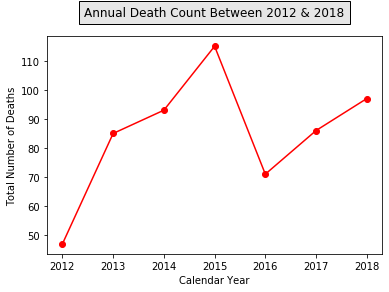

In [66]:
# create a line chart to visualize yearly total death between 2012 and 2018
year = annual_total_death["Year"]
death = annual_total_death["Total Fatality"]
plt.plot(year, death, marker ='o', color='red', label="Sine")

# Adding axis labels
_=plt.title("Annual Death Count Between 2012 & 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Calendar Year")
_=plt.ylabel("Total Number of Deaths")
_=plt.savefig("Images/total_death_per_year.png")

In [67]:
# Create a dataframe to show the annual injury and fatality percentage between 2012 & 2018
injury_percentage_2012 = round((total_2012_injury / total_2012_accidents) * 100, 2)
death_percentage_2012 = round((total_2012_death / total_2012_accidents) * 100, 2)
injury_percentage_2013 = round((total_2013_injury / total_2013_accidents) * 100, 2)
death_percentage_2013 = round((total_2013_death / total_2013_accidents) * 100, 2)
injury_percentage_2014 = round((total_2014_injury / total_2014_accidents) * 100, 2)
death_percentage_2014 = round((total_2014_death / total_2014_accidents) * 100, 2)
injury_percentage_2015 = round((total_2015_injury / total_2015_accidents) * 100, 2)
death_percentage_2015 = round((total_2015_death / total_2015_accidents) * 100, 2)
injury_percentage_2016 = round((total_2016_injury / total_2016_accidents) * 100, 2)
death_percentage_2016 = round((total_2016_death / total_2016_accidents) * 100, 2)
injury_percentage_2017 = round((total_2017_injury / total_2017_accidents) * 100, 2)
death_percentage_2017 = round((total_2017_death / total_2017_accidents) * 100, 2)
injury_percentage_2018 = round((total_2018_injury / total_2018_accidents) * 100, 2)
death_percentage_2018 = round((total_2018_death / total_2018_accidents) * 100, 2)

# create pandas series and dataframe
year = pd.Series(["2012", "2013", "2014", "2015", "2016", "2017", "2018"])
overall_injury_percentage = pd.Series([injury_percentage_2012, injury_percentage_2013, injury_percentage_2014, injury_percentage_2015,
                        injury_percentage_2016, injury_percentage_2017, injury_percentage_2018])
overall_death_percentage = pd.Series([death_percentage_2012, death_percentage_2013, death_percentage_2014, death_percentage_2015,
                        death_percentage_2016, death_percentage_2017, death_percentage_2018])
percentage_dict = {
    "Year": year,
    "Injury Percentage": overall_injury_percentage,
    "Fatality Percentage": overall_death_percentage
}
annual_percentage = pd.DataFrame(percentage_dict)
annual_percentage

,Year,Injury Percentage,Fatality Percentage
0,2012,20.44,0.16
1,2013,20.14,0.14
2,2014,18.66,0.13
3,2015,18.11,0.14
4,2016,19.09,0.08
5,2017,18.89,0.08
6,2018,19.36,0.09


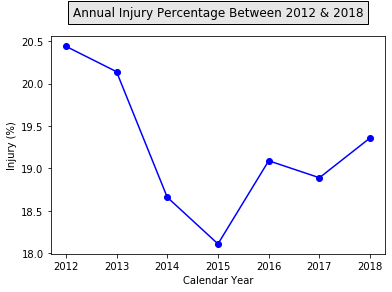

In [68]:
# create a line chart to visualize yearly injury percentage between 2012 and 2018
year = annual_percentage["Year"]
injury_percentage = annual_percentage["Injury Percentage"]
plt.plot(year, injury_percentage, marker ='o', color='blue', label="Sine")

# Adding axis labels
_=plt.title("Annual Injury Percentage Between 2012 & 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Calendar Year")
_=plt.ylabel("Injury (%)")
_=plt.savefig("Images/injury_percentage_per_year.png")

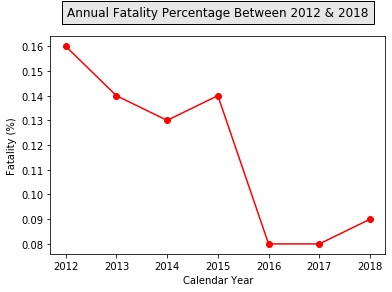

In [69]:
# create a line chart to visualize yearly death percentage between 2012 and 2018
year = annual_percentage["Year"]
death_percentage = annual_percentage["Fatality Percentage"]
plt.plot(year, death_percentage, marker ='o', color='red', label="Sine")

# Adding axis labels
_=plt.title("Annual Fatality Percentage Between 2012 & 2018", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Calendar Year")
_=plt.ylabel("Fatality (%)")
_=plt.savefig("Images/fatality_percentage_per_year.png")

In [70]:
# CitiBikes was launched in NYC in May 2013. They have been expanding the Bike Share program ever since. 
# The purpose of following series of visualizations is to observe any impact of the bikes on the street on accident.
# Create a dataframe to show bike related accident, injury and death
# total number of accidents
total_2012_bike_accident = len(dmv_2012_data.loc[(dmv_2012_data['VEHICLE TYPE CODE 1'] == "BIKE")])
total_2013_bike_accident = len(dmv_2013_data.loc[(dmv_2013_data['VEHICLE TYPE CODE 1'] == "BIKE")])
total_2014_bike_accident = len(dmv_2014_data.loc[(dmv_2014_data['VEHICLE TYPE CODE 1'] == "BIKE")])
total_2015_bike_accident = len(dmv_2015_data.loc[(dmv_2015_data['VEHICLE TYPE CODE 1'] == "BIKE")])
total_2016_bike_accident = len(dmv_2016_data.loc[(dmv_2016_data['VEHICLE TYPE CODE 1'] == "BIKE")])
total_2017_bike_accident = len(dmv_2017_data.loc[(dmv_2017_data['VEHICLE TYPE CODE 1'] == "BIKE")])
total_2018_bike_accident = len(dmv_2018_data.loc[(dmv_2018_data['VEHICLE TYPE CODE 1'] == "BIKE")])

# total number of injuries
total_2012_bike_injury = len(dmv_2012_data.loc[(dmv_2012_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2012_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2013_bike_injury = len(dmv_2013_data.loc[(dmv_2013_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2013_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2014_bike_injury = len(dmv_2014_data.loc[(dmv_2014_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2014_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2015_bike_injury = len(dmv_2015_data.loc[(dmv_2015_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2015_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2016_bike_injury = len(dmv_2016_data.loc[(dmv_2016_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2016_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2017_bike_injury = len(dmv_2017_data.loc[(dmv_2017_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2017_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2018_bike_injury = len(dmv_2018_data.loc[(dmv_2018_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2018_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])

# total number of fatality
total_2012_bike_death = len(dmv_2012_data.loc[(dmv_2012_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2012_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2013_bike_death = len(dmv_2013_data.loc[(dmv_2013_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2013_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2014_bike_death = len(dmv_2014_data.loc[(dmv_2014_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2014_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2015_bike_death = len(dmv_2015_data.loc[(dmv_2015_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2015_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2016_bike_death = len(dmv_2016_data.loc[(dmv_2016_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2016_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2017_bike_death = len(dmv_2017_data.loc[(dmv_2017_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2017_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2018_bike_death = len(dmv_2018_data.loc[(dmv_2018_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2018_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])

# create pandas series and dataframe
year = pd.Series(["2012", "2013", "2014", "2015", "2016", "2017", "2018"])
bike_accident = pd.Series([total_2012_bike_accident, total_2013_bike_accident, total_2014_bike_accident,
                          total_2015_bike_accident, total_2016_bike_accident, total_2017_bike_accident, total_2018_bike_accident])
bike_injury = pd.Series([total_2012_bike_injury, total_2013_bike_injury, total_2014_bike_injury,
                          total_2015_bike_injury, total_2016_bike_injury, total_2017_bike_injury, total_2018_bike_injury])
bike_death = pd.Series([total_2012_bike_death, total_2013_bike_death, total_2014_bike_death,
                          total_2015_bike_death, total_2016_bike_death, total_2017_bike_death, total_2018_bike_death])
bike_dict = {
    "Year": year,
    "Total Accident": bike_accident,
    "Total Injury": bike_injury,
    "Total Fatality": bike_death
}
bike_accident = pd.DataFrame(bike_dict)
bike_accident

,Year,Total Accident,Total Injury,Total Fatality
0,2012,0,0,0
1,2013,0,0,0
2,2014,0,0,0
3,2015,0,0,0
4,2016,112,99,0
5,2017,18,12,0
6,2018,1052,864,1


In [71]:
# Uber was launched in NYC in May 2011. Over the following years there has been a great increase in ride share culture with
# Lyft, Via and other companies coming online and expanding their ride share program. All these companies are covered by the 
# same TLC license as Taxicabs.
# The purpose of following series of visualizations is to observe how increased number of Taxi impacted NYC accidents
# Create a dataframe to show taxi related accident, injury and death
# total number of accidents
total_2012_taxi_accident = len(dmv_2012_data.loc[(dmv_2012_data['VEHICLE TYPE CODE 1'] == "TAXI")])
total_2013_taxi_accident = len(dmv_2013_data.loc[(dmv_2013_data['VEHICLE TYPE CODE 1'] == "TAXI")])
total_2014_taxi_accident = len(dmv_2014_data.loc[(dmv_2014_data['VEHICLE TYPE CODE 1'] == "TAXI")])
total_2015_taxi_accident = len(dmv_2015_data.loc[(dmv_2015_data['VEHICLE TYPE CODE 1'] == "TAXI")])
total_2016_taxi_accident = len(dmv_2016_data.loc[(dmv_2016_data['VEHICLE TYPE CODE 1'] == "TAXI")])
total_2017_taxi_accident = len(dmv_2017_data.loc[(dmv_2017_data['VEHICLE TYPE CODE 1'] == "TAXI")])
total_2018_taxi_accident = len(dmv_2018_data.loc[(dmv_2018_data['VEHICLE TYPE CODE 1'] == "TAXI")])

# total number of injuries
total_2012_taxi_injury = len(dmv_2012_data.loc[(dmv_2012_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2012_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2013_taxi_injury = len(dmv_2013_data.loc[(dmv_2013_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2013_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2014_taxi_injury = len(dmv_2014_data.loc[(dmv_2014_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2014_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2015_taxi_injury = len(dmv_2015_data.loc[(dmv_2015_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2015_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2016_taxi_injury = len(dmv_2016_data.loc[(dmv_2016_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2016_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2017_taxi_injury = len(dmv_2017_data.loc[(dmv_2017_data['VEHICLE TYPE CODE 1'] == "BIKE") & (dmv_2017_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])
total_2018_taxi_injury = len(dmv_2018_data.loc[(dmv_2018_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2018_data['NUMBER OF PERSONS INJURED'].astype(int) > 0)])

# total number of fatality
total_2012_taxi_death = len(dmv_2012_data.loc[(dmv_2012_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2012_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2013_taxi_death = len(dmv_2013_data.loc[(dmv_2013_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2013_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2014_taxi_death = len(dmv_2014_data.loc[(dmv_2014_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2014_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2015_taxi_death = len(dmv_2015_data.loc[(dmv_2015_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2015_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2016_taxi_death = len(dmv_2016_data.loc[(dmv_2016_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2016_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2017_taxi_death = len(dmv_2017_data.loc[(dmv_2017_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2017_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])
total_2018_taxi_death = len(dmv_2018_data.loc[(dmv_2018_data['VEHICLE TYPE CODE 1'] == "TAXI") & (dmv_2018_data['NUMBER OF PERSONS KILLED'].astype(int) > 0)])

# Percentage of accident caused by Taxi
taxi_2012_accidents_percentage = round((total_2012_taxi_accident / total_2012_accidents) * 100, 2)
taxi_2013_accidents_percentage = round((total_2013_taxi_accident / total_2013_accidents) * 100, 2)
taxi_2014_accidents_percentage = round((total_2014_taxi_accident / total_2014_accidents) * 100, 2)
taxi_2015_accidents_percentage = round((total_2015_taxi_accident / total_2015_accidents) * 100, 2)
taxi_2016_accidents_percentage = round((total_2016_taxi_accident / total_2016_accidents) * 100, 2)
taxi_2017_accidents_percentage = round((total_2017_taxi_accident / total_2017_accidents) * 100, 2)
taxi_2018_accidents_percentage = round((total_2018_taxi_accident / total_2018_accidents) * 100, 2)


# Percentage of injury caused by Taxi
taxi_2012_injury_percentage = round((total_2012_taxi_injury / total_2012_injury) * 100, 2)
taxi_2013_injury_percentage = round((total_2013_taxi_injury / total_2013_injury) * 100, 2)
taxi_2014_injury_percentage = round((total_2014_taxi_injury / total_2014_injury) * 100, 2)
taxi_2015_injury_percentage = round((total_2015_taxi_injury / total_2015_injury) * 100, 2)
taxi_2016_injury_percentage = round((total_2016_taxi_injury / total_2016_injury) * 100, 2)
taxi_2017_injury_percentage = round((total_2017_taxi_injury / total_2017_injury) * 100, 2)
taxi_2018_injury_percentage = round((total_2018_taxi_injury / total_2018_injury) * 100, 2)

# create pandas series and dataframe
year = pd.Series(["2012", "2013", "2014", "2015", "2016", "2017", "2018"])
taxi_accident = pd.Series([total_2012_taxi_accident, total_2013_taxi_accident, total_2014_taxi_accident,
                          total_2015_taxi_accident, total_2016_taxi_accident, total_2017_taxi_accident, total_2018_taxi_accident])
taxi_injury = pd.Series([total_2012_taxi_injury, total_2013_taxi_injury, total_2014_taxi_injury,
                          total_2015_taxi_injury, total_2016_taxi_injury, total_2017_taxi_injury, total_2018_taxi_injury])
taxi_death = pd.Series([total_2012_taxi_death, total_2013_taxi_death, total_2014_taxi_death,
                          total_2015_taxi_death, total_2016_taxi_death, total_2017_taxi_death, total_2018_taxi_death])
taxi_accident_percentage = pd.Series([taxi_2012_accidents_percentage, taxi_2013_accidents_percentage, taxi_2014_accidents_percentage,
                            taxi_2015_accidents_percentage, taxi_2016_accidents_percentage, taxi_2017_accidents_percentage,
                            taxi_2018_accidents_percentage])
taxi_injury_percentage = pd.Series([taxi_2012_injury_percentage, taxi_2013_injury_percentage, taxi_2014_injury_percentage,
                            taxi_2015_injury_percentage, taxi_2016_injury_percentage, taxi_2017_injury_percentage,
                            taxi_2018_injury_percentage])
taxi_dict = {
    "Year": year,
    "Taxi Accident": taxi_accident,
    "Taxi Injury": taxi_injury,
    "Taxi Fatality": taxi_death,
    "% Accident by Taxi": taxi_accident_percentage,
    "% Injury by Taxi": taxi_injury_percentage,
    "% Overall Accident Injury": overall_injury_percentage
}
taxi_accident = pd.DataFrame(taxi_dict)
taxi_accident

,Year,Taxi Accident,Taxi Injury,Taxi Fatality,% Accident by Taxi,% Injury by Taxi,% Overall Accident Injury
0,2012,1839,385,1,6.25,6.40,20.44
1,2013,4007,826,2,6.62,6.77,20.14
2,2014,4698,910,3,6.76,7.02,18.66
3,2015,5002,973,7,5.93,6.37,18.11
4,2016,2925,562,0,3.13,3.15,19.09
5,2017,5679,12,4,5.47,0.06,18.89
6,2018,6060,1228,3,5.59,5.85,19.36


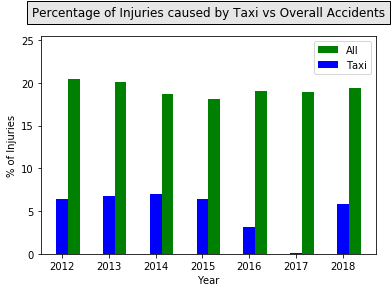

In [72]:
# Create a bar chart to compare injury caused by taxi vs overall collison related injury
year = taxi_accident["Year"]
accident_by_taxi = taxi_accident["% Injury by Taxi"]
all_accident = taxi_accident["% Overall Accident Injury"]
p1=plt.bar(year.astype(int)+0.25, all_accident, color='g', width=0.25, align="center")
p2=plt.bar(year.astype(int), accident_by_taxi, color='b', width=0.25, align="center")
_=plt.title("Percentage of Injuries caused by Taxi vs Overall Accidents", bbox={'facecolor':'0.9', 'pad':5}, pad=20)
_=plt.xlabel("Year")
_=plt.ylabel("% of Injuries")
_=plt.ylim(0, max(all_accident)+5)
_=plt.legend((p1[0], p2[0]), ('All', 'Taxi'))
taxi_accident
plt.savefig("Images/Injury_by_taxi_vs_all.png")